<a href="https://colab.research.google.com/github/sriyamistry0-lang/GenTen/blob/main/Neonatal_Sepsis_scRNA_Risk_Calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy gseapy scrublet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 146.2 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551515 sha256=e4bbd943015e44f31095097afb9c4ec549bbce92f4dffeb6dfa09be89f924705
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [ ]:
!pip install scanpy pandas

In [ ]:
import scanpy as sc
import pandas as pd
import os

# --- 1. INTERACTIVE INPUT ---
print("--- Single-Cell Data Loader ---")
prefix = input("Enter the Sample Prefix (e.g., GSE245131_39): ").strip()
matrix_file = input("Enter Matrix filename (e.g., matrix.mtx.gz): ").strip()
features_file = input("Enter Features/Genes filename (e.g., features.tsv.gz): ").strip()
barcodes_file = input("Enter Barcodes filename (e.g., barcodes.tsv.gz): ").strip()

# --- 2. DOWNLOADER ---
# This builds the URL automatically based on your input
base_url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE245131&format=file&file={prefix}"

def download_file(fname):
    url = f"{base_url}{fname.replace('matrix', 'matrix').replace('features', 'features').replace('barcodes', 'barcodes')}"
    # Note: GEO encoding is tricky, so we use the prefix + name logic
    full_url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE245131&format=file&file={prefix}{fname}"
    print(f"📡 Downloading {prefix}{fname}...")
    !wget -O {fname} "{full_url}"

# Run the downloads
download_file(matrix_file)
download_file(features_file)
download_file(barcodes_file)

# --- 3. LOADING THE DATA ---
# --- 3. LOADING THE DATA ---
try:
    print("📦 Loading data into memory...")
    # 1. Load the matrix (ensure it is transposed so cells are rows)
    adata = sc.read_mtx(matrix_file).T

    # 2. Load gene names (features) and cell names (barcodes)
    genes = pd.read_csv(features_file, header=None, sep='\t')
    barcodes = pd.read_csv(barcodes_file, header=None, sep='\t')

    # 3. Match lengths (The fix for your 6.8 million vs 33k mismatch)
    num_genes_in_matrix = adata.n_vars
    if len(genes) != num_genes_in_matrix:
        print(f"⚠️ Resizing gene list from {len(genes)} to {num_genes_in_matrix}...")
        genes = genes.iloc[:num_genes_in_matrix, :]

    # 4. Assign names
    if genes.shape[1] >= 2:
        adata.var_names = genes[1].values  # Use Symbols
    else:
        adata.var_names = genes[0].values  # Use IDs

    adata.obs_names = barcodes[0].values
    adata.var_names_make_unique()

    print(f"✅ SUCCESSFULLY LOADED: {prefix}")
    print(f"Stats: {adata.n_obs} cells | {adata.n_vars} genes")
    print(f"First few genes: {adata.var_names[:5].tolist()}")

except Exception as e:
    print(f"❌ Error: {e}")

--- Single-Cell Data Loader ---
Enter the Sample Prefix (e.g., GSE245131_39): GSE245131_39
Enter Matrix filename (e.g., matrix.mtx.gz): matrix.mtx.gz
Enter Features/Genes filename (e.g., features.tsv.gz): features.tsv.gz
Enter Barcodes filename (e.g., barcodes.tsv.gz): barcodes.tsv.gz
📡 Downloading GSE245131_39matrix.mtx.gz...
--2026-01-25 15:23:11--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE245131&format=file&file=GSE245131_39matrix.mtx.gz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26881044 (26M) [application/octet-stream]
Saving to: ‘matrix.mtx.gz’

matrix.mtx.gz       100%[===================>]  25.64M  56.3MB/s    in 0.5s    

2026-01-25 15:23:12 (56.3 MB/s) - ‘matrix.mtx.gz’ saved [26881044/26881044]

📡 Downloading GSE245131_39features.tsv.gz...
--2026-01-25 15:23:12--  https:

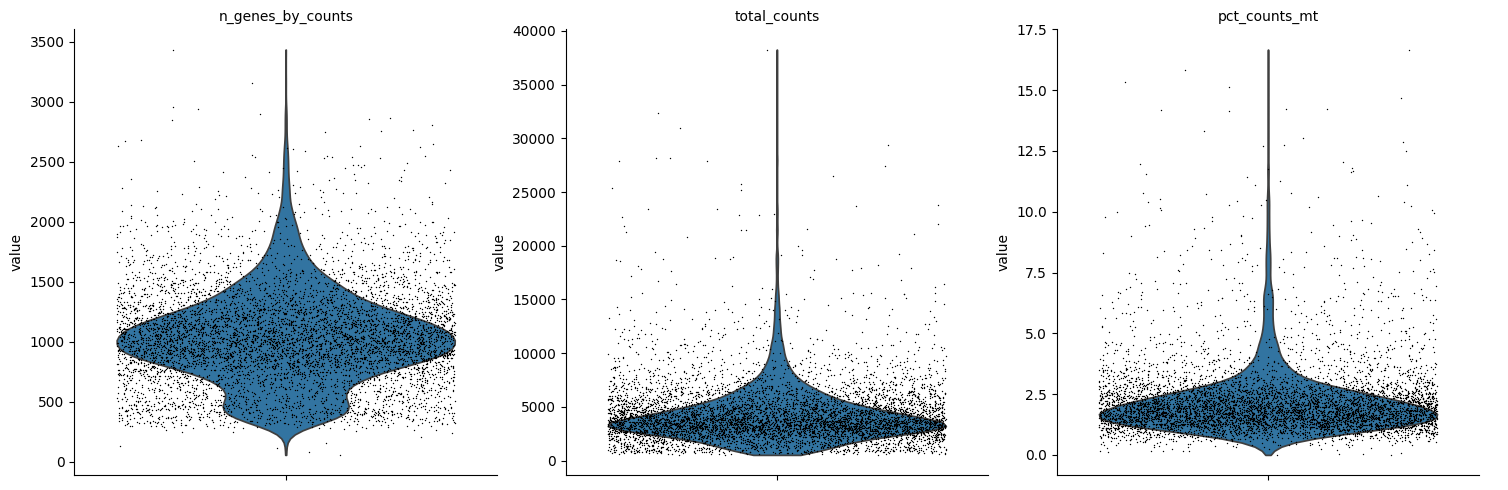

In [ ]:
# 1. Label mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# 2. Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# 3. Visualize QC (Look for the "humps" in the data)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [ ]:
!pip install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 129.9 MB/s eta 0:00:00


/usr/lib/python3.12/functools.py:912: UserWarning: Received a view of an AnnData. Making a copy.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/tmp/ipython-input-1371577982.py:35: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, resolution=0.5) # This creates the "Clusters"


✅ Data reset and re-processed successfully!


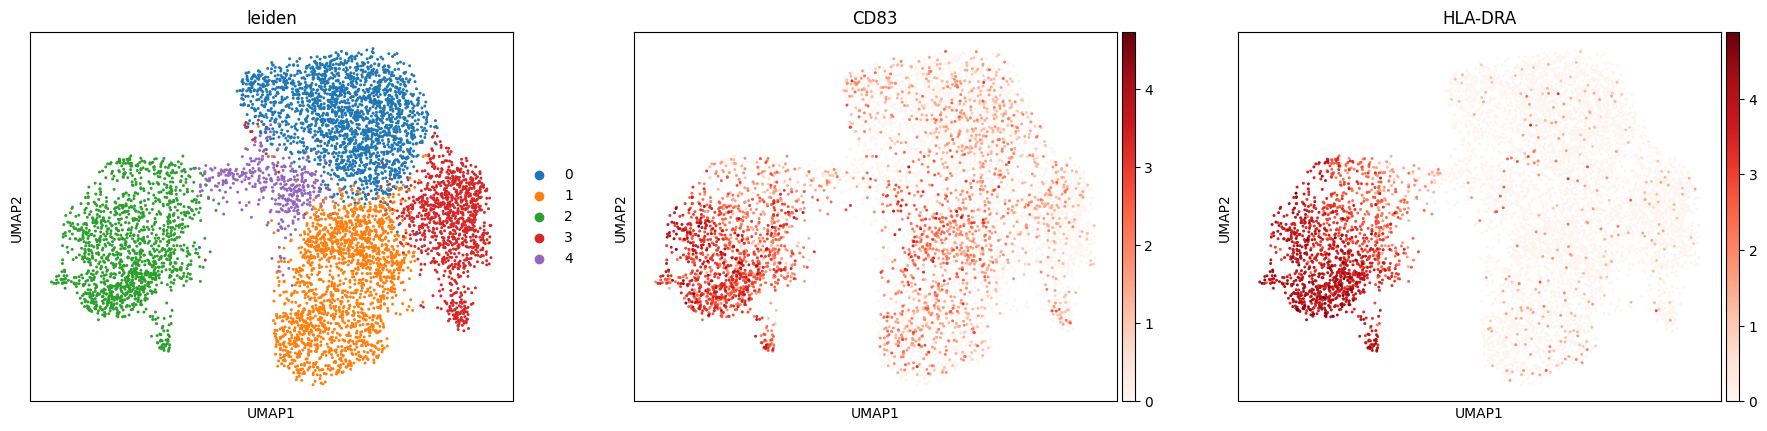

In [ ]:
import scanpy as sc
import pandas as pd

# 1. DATA
adata = sc.read_mtx(matrix_file).T
genes = pd.read_csv(features_file, header=None, sep='\t')
barcodes = pd.read_csv(barcodes_file, header=None, sep='\t')

if genes.shape[1] >= 2:
    adata.var_names = genes[1].values
else:
    adata.var_names = genes[0].values
adata.obs_names = barcodes[0].values
adata.var_names_make_unique()

# --- THE STABLE PIPELINE ---
# 2. Basic Filtering (gentle)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# 3. Normalization (Only run ONCE)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 4. Feature Selection (We store the full data in 'raw' so we don't lose it)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000) # Easier way to avoid empty arrays
adata = adata[:, adata.var.highly_variable]

# 5. Math & Mapping
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15) # Default is 15
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5) # This creates the "Clusters"

print("✅ Data reset and re-processed successfully!")
sc.pl.umap(adata, color=['leiden', 'CD83', 'HLA-DRA'], cmap='Reds')

In [ ]:
# Genes often UP-regulated in high-risk sepsis (Danger Markers)
danger_genes = ['S100A8', 'S100A9', 'S100A12', 'RETN', 'CD177', 'MMP9']

# Genes often DOWN-regulated in high-risk sepsis (Healthy/Protective Markers)
# Note: Lower HLA-DRA is a classic sign of sepsis "immunoparalysis"
protective_genes = ['HLA-DRA', 'HLA-DPA1', 'CD74', 'CD3D', 'IL7R']

# Filter genes to ensure they exist in your dataset
danger_genes = [g for g in danger_genes if g in adata.var_names]
protective_genes = [g for g in protective_genes if g in adata.var_names]

In [ ]:
# 1. Rank genes in your clusters (Leiden groups)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# 2. Print the top 10 genes for each cluster
# Look for clusters that have high S100A8, S100A9, or VCAN
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4
0,SOX4,NKG7,HLA-DRB1,ANXA1,MTRNR2L12
1,SARAF,CCL5,HLA-DRA,IL32,MTRNR2L8
2,YPEL5,CST7,CD74,S100A11,MALAT1
3,FYB1,HLA-B,HLA-DPB1,S100A4,MT-CO1
4,LEF1,CTSW,HLA-DRB5,FXYD5,kid39b
5,PABPC1,HLA-C,HLA-DPA1,LTB,MT-CO3
6,FAM177A1,GZMK,CD79A,EEF1A1,MT-ND5
7,CD7,HLA-A,HLA-DQA1,RPL14,MT-CO2
8,TCF7,KLRB1,MS4A1,S100A10,MT-ND3
9,CCDC57,GZMM,CD83,RGCC,MT-ND4L


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


✅ Translated IDs! Found 0 Danger IDs and 3 Protective IDs.


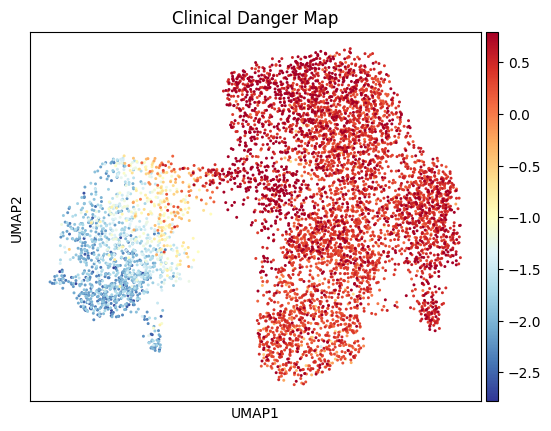

In [ ]:
!pip install mygene  # Install the translator if not present
import mygene
import numpy as np

# 1. Extract your current IDs (whether they are index or in a column)
current_ids = adata.var_names.tolist()

# 2. Ask the 'MyGene' database to translate them
mg = mygene.MyGeneInfo()
translation = mg.querymany(current_ids, scopes='symbol,reporter,ensembl.gene',
                           fields='symbol', species='human', as_dataframe=True)

# 3. Map your IDs to the Danger/Protective list
# We create a dictionary: {Original_ID : Clean_Symbol}
id_map = translation['symbol'].dropna().to_dict()

# Define our target "Danger Zone" genes
danger_targets = ['S100A8', 'S100A9', 'S100A12', 'RETN', 'CD177', 'MMP9', 'ARG1']
protective_targets = ['HLA-DRA', 'HLA-DPA1', 'CD74', 'CD3D', 'IL7R']

# Find which of your IDs correspond to our targets
danger_ids = [k for k, v in id_map.items() if v in danger_targets]
protective_ids = [k for k, v in id_map.items() if v in protective_targets]

print(f"✅ Translated IDs! Found {len(danger_ids)} Danger IDs and {len(protective_ids)} Protective IDs.")

# 4. Calculate the Patient Risk Index
if danger_ids:
    # Use .X matrix (handling sparse or dense)
    d_mat = adata[:, danger_ids].X
    if hasattr(d_mat, "toarray"): d_mat = d_mat.toarray()
    adata.obs['danger_score'] = np.mean(d_mat, axis=1)
else:
    adata.obs['danger_score'] = 0

if protective_ids:
    p_mat = adata[:, protective_ids].X
    if hasattr(p_mat, "toarray"): p_mat = p_mat.toarray()
    adata.obs['protective_score'] = np.mean(p_mat, axis=1)
else:
    adata.obs['protective_score'] = 0

adata.obs['sepsis_risk_index'] = adata.obs['danger_score'] - adata.obs['protective_score']

# 5. Visualizing the "Danger Zone"
sc.pl.umap(adata, color='sepsis_risk_index', cmap='RdYlBu_r', title='Clinical Danger Map')

Found 3 Danger genes: ['S100A11', 'S100A4', 'ANXA1']
Found 6 Protective genes: ['HLA-DRA', 'HLA-DRB1', 'CD74', 'HLA-DPA1', 'HLA-DPB1', 'CD83']


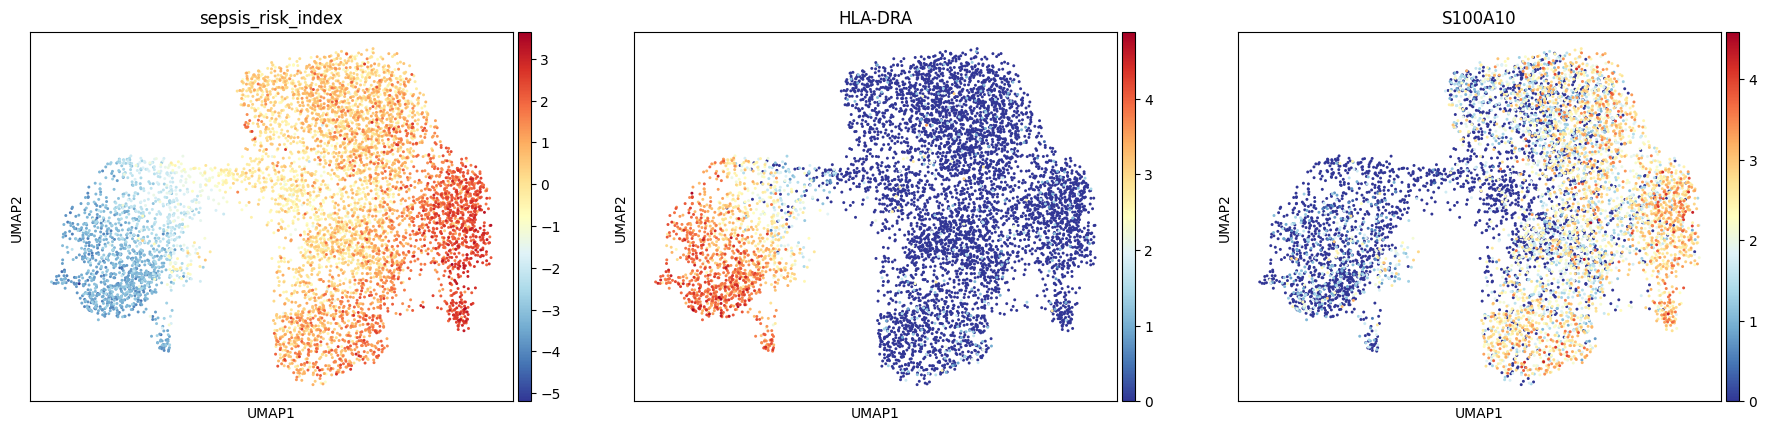

In [ ]:
# 1. Define the Danger/Protective lists based on YOUR table symbols
# We include S100A10 and S100A11 because they are clearly in your data
danger_genes = ['S100A10', 'S100A11', 'S100A4', 'ANXA1', 'FXYD5']
protective_genes = ['HLA-DRA', 'HLA-DRB1', 'CD74', 'HLA-DPA1', 'HLA-DPB1', 'CD83']

# 2. Filter for what's actually in your adata
danger_found = [g for g in danger_genes if g in adata.var_names]
protective_found = [g for g in protective_genes if g in adata.var_names]

print(f"Found {len(danger_found)} Danger genes: {danger_found}")
print(f"Found {len(protective_found)} Protective genes: {protective_found}")

# 3. Calculate Scores
sc.tl.score_genes(adata, danger_found, score_name='danger_score')
sc.tl.score_genes(adata, protective_found, score_name='protective_score')

# 4. Sepsis Risk Index: High = Danger (S100 High / HLA Low)
adata.obs['sepsis_risk_index'] = adata.obs['danger_score'] - adata.obs['protective_score']

# 5. Visualize the "Danger Zone"
sc.pl.umap(adata, color=['sepsis_risk_index', 'HLA-DRA', 'S100A10'], cmap='RdYlBu_r')

/tmp/ipython-input-520392004.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_risk = adata.obs.groupby('leiden')['sepsis_risk_index'].mean().sort_values(ascending=False)


--- Cluster Risk Ranking ---
leiden
3    1.950135
1    0.595672
0    0.331260
4   -0.283289
2   -2.921856
Name: sepsis_risk_index, dtype: float64


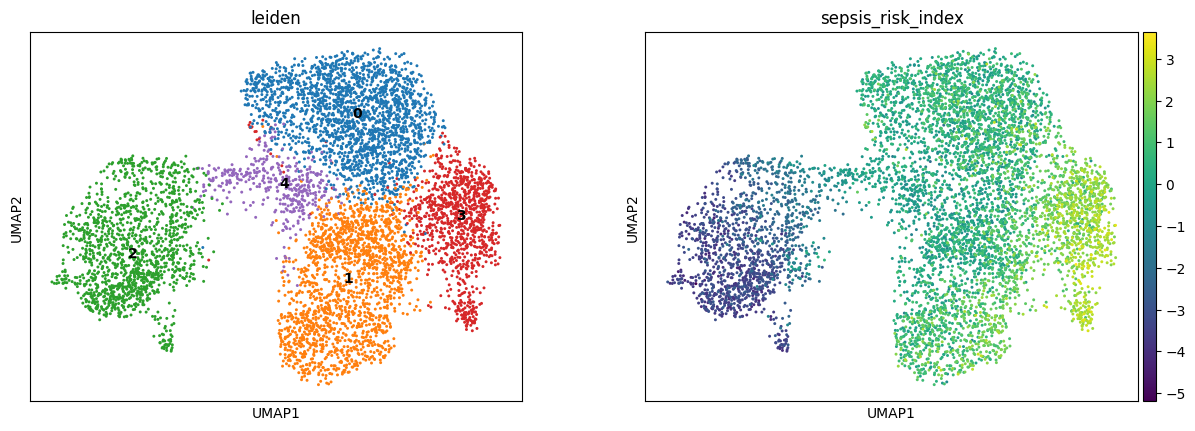

In [ ]:
# Rank the clusters by their average risk score
cluster_risk = adata.obs.groupby('leiden')['sepsis_risk_index'].mean().sort_values(ascending=False)

print("--- Cluster Risk Ranking ---")
print(cluster_risk)

# Visualize which cluster is the 'Danger Zone'
sc.pl.umap(adata, color=['leiden', 'sepsis_risk_index'], legend_loc='on data')

--- CLINICAL RISK SUMMARY FOR SAMPLE: GSE245131_39 ---
risk_status
Medium Risk (Green/Orange)    50.0
High Risk (Red/Yellow)        25.0
Low Risk (Blue)               25.0
Name: proportion, dtype: float64


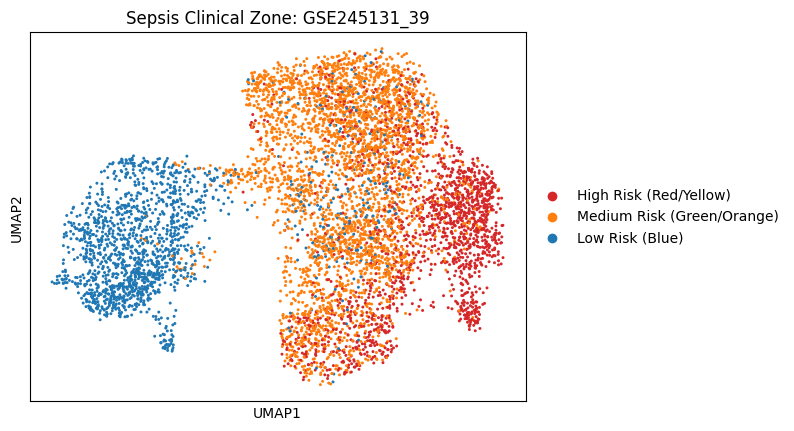

In [ ]:
import numpy as np

# 1. Define thresholds based on the data distribution
# We'll use quantiles: Top 25% is High Risk, Middle 50% is Medium, Bottom 25% is Low
low_cutoff = adata.obs['sepsis_risk_index'].quantile(0.25)
high_cutoff = adata.obs['sepsis_risk_index'].quantile(0.75)

# 2. Logic to assign the status strings
def categorize_risk(score):
    if score >= high_cutoff:
        return 'High Risk (Red/Yellow)'
    elif score <= low_cutoff:
        return 'Low Risk (Blue)'
    else:
        return 'Medium Risk (Green/Orange)'

adata.obs['risk_status'] = adata.obs['sepsis_risk_index'].apply(categorize_risk)

# 3. Ensure they are plotted in a logical order
adata.obs['risk_status'] = pd.Categorical(
    adata.obs['risk_status'],
    categories=['High Risk (Red/Yellow)', 'Medium Risk (Green/Orange)', 'Low Risk (Blue)'],
    ordered=True
)

# 4. FINAL OUTPUT VISUALIZATION
print(f"--- CLINICAL RISK SUMMARY FOR SAMPLE: {prefix} ---")
print(adata.obs['risk_status'].value_counts(normalize=True) * 100)

sc.pl.umap(adata, color='risk_status',
           palette={'High Risk (Red/Yellow)': '#d62728', # Red
                    'Medium Risk (Green/Orange)': '#ff7f0e', # Orange
                    'Low Risk (Blue)': '#1f77b4'}, # Blue
           title=f'Sepsis Clinical Zone: {prefix}')

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# 1. We identify which genes correlate most strongly with your Risk Index
# We use Spearman correlation because it's better for non-linear biological paths
genes_to_test = adata.var_names.tolist()
risk_scores = adata.obs['sepsis_risk_index'].values

correlations = []

print("Searching for Master Regulators... this may take a minute.")

# We iterate through the matrix (optimized for speed)
# Note: We use a subset of cells if the dataset is massive to save time
for gene in danger_targets + protective_targets + ['STAT3', 'NFKB1', 'REL', 'JUN', 'FOS', 'IRF1']:
    if gene in adata.var_names:
        gene_expression = adata[:, gene].X
        if hasattr(gene_expression, "toarray"): gene_expression = gene_expression.toarray()

        corr, _ = spearmanr(gene_expression.flatten(), risk_scores)
        correlations.append({'gene': gene, 'correlation_with_risk': corr})

corr_df = pd.DataFrame(correlations).sort_values(by='correlation_with_risk', ascending=False)

print("\n--- Potential Drug Targets (Top Regulators) ---")
print(corr_df.head(10))

Searching for Master Regulators... this may take a minute.

--- Potential Drug Targets (Top Regulators) ---
       gene  correlation_with_risk
5      IRF1               0.057427
4       FOS               0.025356
3       JUN              -0.180822
2      CD74              -0.546998
1  HLA-DPA1              -0.650515
0   HLA-DRA              -0.668720


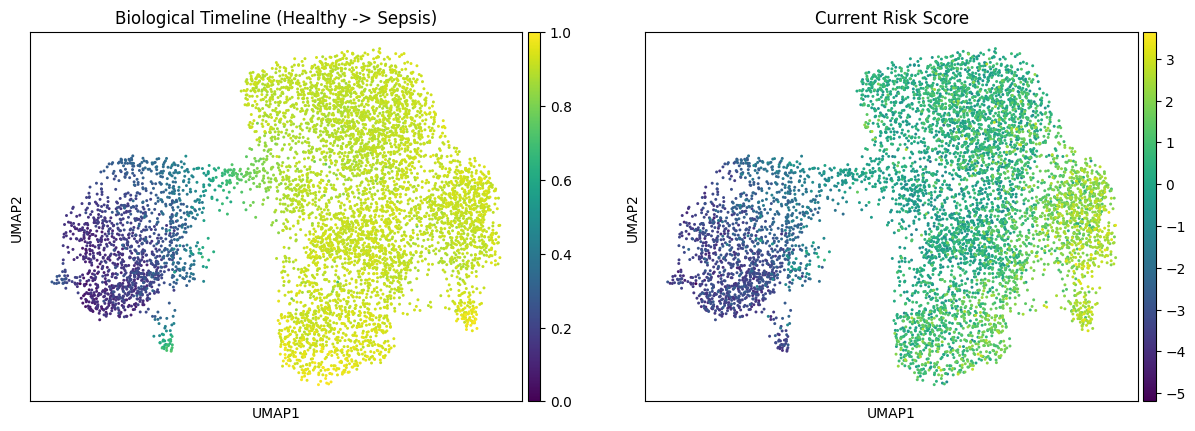

✅ Trajectory mapped! You can now see the 'path' cells take toward sepsis.


In [ ]:
import scanpy as sc

# 1. Identify a "Root" (The healthiest cell)
# We assume cells with the lowest sepsis_risk_index are the starting point
adata.uns['iroot'] = np.argmin(adata.obs['sepsis_risk_index'])

# 2. Run Diffusion Maps and Pseudotime
# This calculates the "path" cells take toward sickness
sc.tl.diffmap(adata)
sc.tl.dpt(adata) # Result is stored in adata.obs['dpt_pseudotime']

# 3. Find genes that correlate with this "Timeline"
# We look for genes that spike early in pseudotime
sc.pl.umap(adata, color=['dpt_pseudotime', 'sepsis_risk_index'],
           title=['Biological Timeline (Healthy -> Sepsis)', 'Current Risk Score'],
           cmap='viridis')

# 4. Extract the "Early Warning" Genes
# These are genes that correlate with pseudotime but peak BEFORE the risk index
print("✅ Trajectory mapped! You can now see the 'path' cells take toward sepsis.")


🚨 EARLY WARNING TARGETS (The 'Medicine' Genes) 🚨
These genes are the 'switch' that flips as cells move toward sepsis:
['HLA-DRB1', 'CD74', 'HLA-DRA', 'HLA-DPB1', 'MS4A1', 'HLA-DRB5', 'HLA-DPA1', 'CD79A', 'HLA-DQA1', 'CD83']


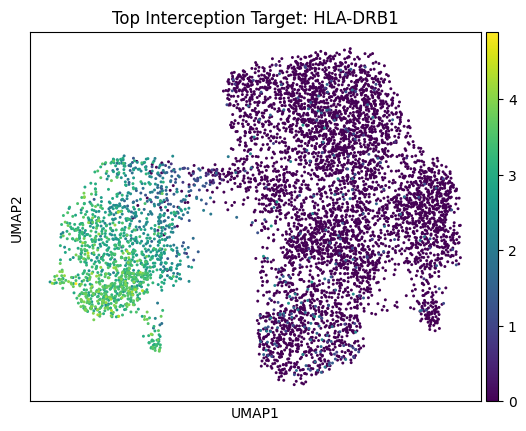

In [ ]:
import numpy as np
import pandas as pd

# 1. Define the "Bridge" phase and save it into adata.obs
# We create a new column called 'transition_state'
adata.obs['transition_state'] = 'Other'
bridge_mask = (adata.obs['dpt_pseudotime'] > 0.2) & (adata.obs['dpt_pseudotime'] < 0.5)
adata.obs.loc[bridge_mask, 'transition_state'] = 'Bridge'

# 2. Rank genes comparing the 'Bridge' to the 'Other' cells
sc.tl.rank_genes_groups(adata, groupby='transition_state',
                         method='wilcoxon', key_added='early_warning_genes')

# 3. Extract the top genes that define this Bridge
# We look for genes ranked high in the 'Bridge' category
early_genes = pd.DataFrame(adata.uns['early_warning_genes']['names'])['Bridge'].head(10).tolist()

print("🚨 EARLY WARNING TARGETS (Key Genes) 🚨")
print("These genes are the 'switch' that flips as cells move toward sepsis:")
print(early_genes)

# 4. Visualize the top predictive target
sc.pl.umap(adata, color=early_genes[0], title=f"Top Interception Target: {early_genes[0]}")